# Client Retention and Gender Analysis

This notebook analyzes the `clients_months.csv` dataset to understand client retention, gender distribution, and gym attendance frequency.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [23]:
# Load the dataset
df = pd.read_csv('../data/04-processed/gym_routines_by_month.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%Y')

# Display first few rows
df.head()

,client_id,date,gender,day
0,0,2023-01-01,M,1
1,0,2022-08-01,M,1
2,0,2022-09-01,M,1
3,0,2022-11-01,M,1
4,1,2024-01-01,M,3


In [24]:
# I will filter the first month because it has only 2 routines
print(f"Rows before filter: {df.shape[0]}")
df = df[df['date'] != '2022-07']
print(f"Rows after filter: {df.shape[0]}")

Rows before filter: 3127
Rows after filter: 3125


## 1. Gender Analysis

Let's look at the distribution of clients by gender.

C:\Users\alejo\AppData\Local\Temp\ipykernel_2708\3797613857.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='gender', order=['F', 'M'], palette={'F': 'salmon', 'M': 'skyblue'})


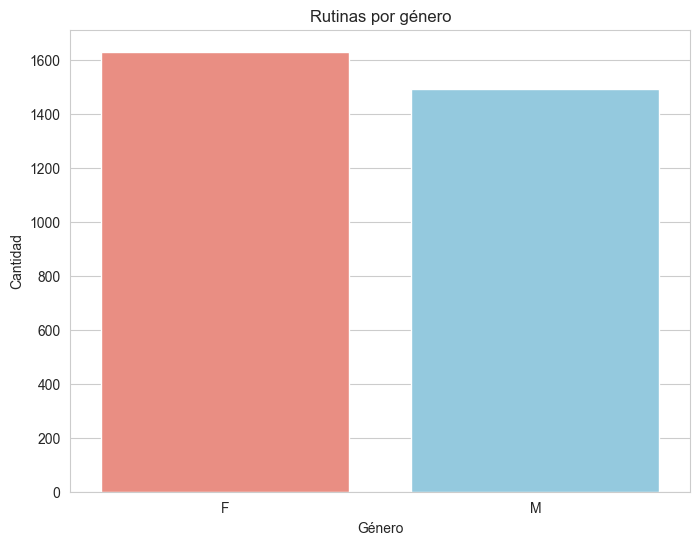

In [25]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='gender', order=['F', 'M'], palette={'F': 'salmon', 'M': 'skyblue'})
plt.title('Rutinas por género')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.show()

Unique clients by gender:
gender
F    332
M    273
Name: count, dtype: int64


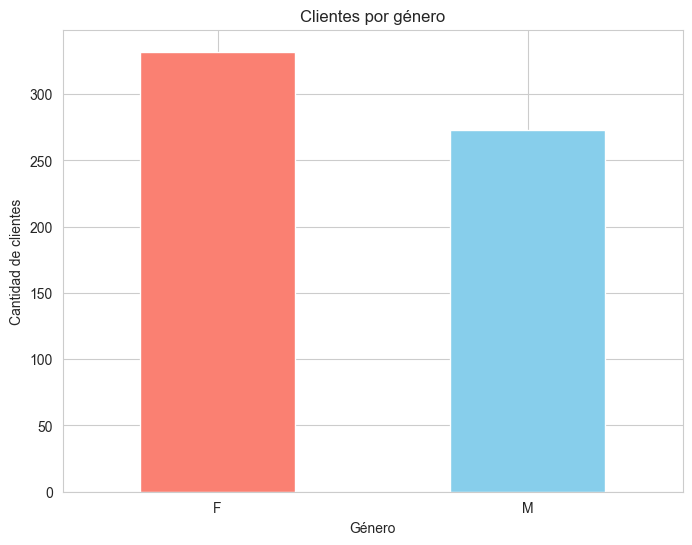

In [26]:
# Unique clients by gender
unique_clients_gender = df.drop_duplicates(subset=['client_id'])['gender'].value_counts()
print("Unique clients by gender:")
print(unique_clients_gender)

plt.figure(figsize=(8, 6))
unique_clients_gender.plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Clientes por género')
plt.xlabel('Género')
plt.ylabel('Cantidad de clientes')
plt.xticks(rotation=0)
plt.show()

## 2. Retention Analysis (Cohort Analysis)

We will perform a cohort analysis to track client retention over time. 
A cohort is defined as a group of users who started their activity in the same month.

In [74]:
df['average_of_days_per_routine'] = df.groupby('client_id')['day'].transform('mean')
df.sample(5)

,client_id,date,gender,day,cohort_month,cohort_index,date_str,year,average_of_days_per_routine
2436,312,2025-05-01,M,1,2025-05-01,1,2025-05,2025,1.000000
857,71,2023-09-01,M,5,2023-01-01,9,2023-09,2023,3.333333
605,49,2025-12-01,F,1,2022-09-01,40,2025-12,2025,1.000000
2698,422,2024-04-01,M,1,2024-02-01,3,2024-04,2024,1.000000
3000,556,2025-09-01,F,1,2025-09-01,1,2025-09,2025,1.000000


In [104]:
def get_retention(df):
    # 1. Assign cohort month (first month of activity for each client)
    df['cohort_month'] = df.groupby('client_id')['date'].transform('min')

    # 2. Calculate cohort index (number of months since start)
    def get_date_int(df, column):
        year = df[column].dt.year
        month = df[column].dt.month
        return year, month

    activity_year, activity_month = get_date_int(df, 'date')
    cohort_year, cohort_month = get_date_int(df, 'cohort_month')

    years_diff = activity_year - cohort_year
    months_diff = activity_month - cohort_month

    df['cohort_index'] = years_diff * 12 + months_diff + 1

    # 3. Count monthly active customers from each cohort
    grouping = df.groupby(['cohort_month', 'cohort_index'])
    cohort_data = grouping['client_id'].apply(pd.Series.nunique).reset_index()

    # 4. Create pivot table
    cohort_counts = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='client_id')

    # 5. Calculate retention rate
    retention = cohort_counts.divide(cohort_sizes, axis=0)

    # Format index for better readability in plot
    retention.index = retention.index.strftime('%Y-%m')

    retention.fillna(0, inplace=True)
    return retention

retention = get_retention(df)
retention.head()

cohort_index,1,2,3,4,5,6,7,8,9,10,...,32,33,34,35,36,37,38,39,40,41
cohort_month,,,,,,,,,,,,,,,,,,,,,
2022-08,1.0,0.405405,0.729730,0.513514,0.297297,0.324324,0.243243,0.378378,0.405405,0.486486,...,0.108108,0.162162,0.108108,0.054054,0.054054,0.162162,0.135135,0.108108,0.108108,0.054054
2022-09,1.0,0.714286,0.428571,0.142857,0.500000,0.142857,0.214286,0.142857,0.142857,0.071429,...,0.000000,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.000000,0.071429,0.000000
2022-10,1.0,0.533333,0.466667,0.333333,0.266667,0.200000,0.266667,0.466667,0.400000,0.466667,...,0.133333,0.133333,0.200000,0.200000,0.266667,0.000000,0.200000,0.133333,0.000000,0.000000
2022-11,1.0,0.461538,0.384615,0.307692,0.076923,0.153846,0.153846,0.153846,0.153846,0.230769,...,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000
2022-12,1.0,0.333333,0.333333,0.333333,0.000000,0.333333,0.222222,0.222222,0.222222,0.222222,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


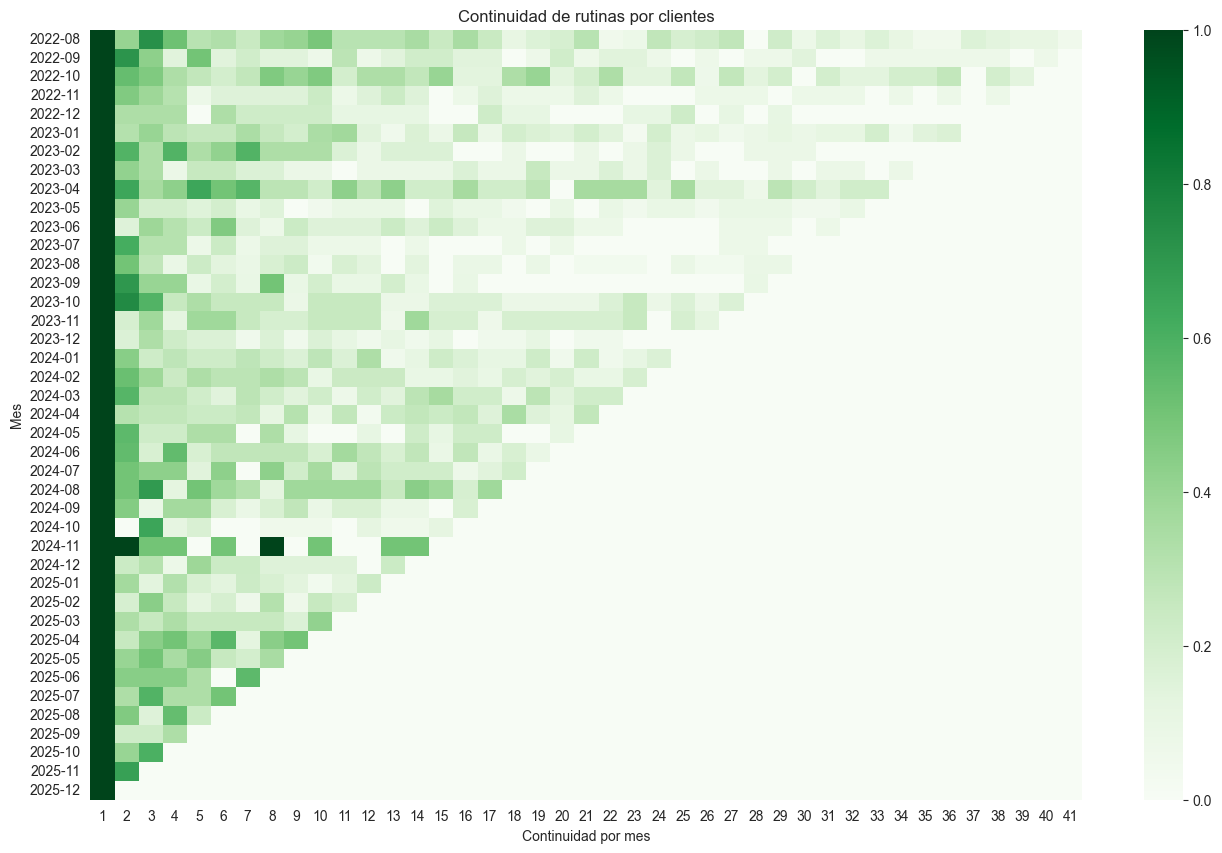

In [ ]:
def plot_retention(retention):
    plt.figure(figsize=(16, 10))
    sns.heatmap(retention, fmt='.0%', cmap='Greens')
    plt.title('Continuidad de rutinas por clientes')
    plt.ylabel('Mes')
    plt.xlabel('Continuidad por mes')
    plt.show()

plot_retention(retention)

In [136]:
def get_avg_lifetime(df):
    user_lifetimes = df.groupby('client_id')['cohort_index'].nunique()
    avg_lifetime = user_lifetimes.mean()
    return avg_lifetime

print(f'Cantidad de rutinas promedio para clientes: {get_avg_lifetime(df)}')
print(f'Cantidad de rutinas promedio para clientes con rutinas de 4 o más días: {get_avg_lifetime(df[df["average_of_days_per_routine"] >= 4])}')
print(f'Cantidad de rutinas promedio para clientes con rutinas de 3 o más días: {get_avg_lifetime(df[df["average_of_days_per_routine"] >= 3])}')
print(f'Cantidad de rutinas promedio para clientes con rutinas entre 2 y 3 días: {get_avg_lifetime(df[(df["average_of_days_per_routine"] >= 2) & (df["average_of_days_per_routine"] <= 3)])}')
print(f'Cantidad de rutinas promedio para clientes con rutinas entre 1.5 y 2 días: {get_avg_lifetime(df[(df["average_of_days_per_routine"] >= 1.5) & (df["average_of_days_per_routine"] <= 2)])}')
print(f'Cantidad de rutinas promedio para clientes con rutinas de menos de 1.5 días: {get_avg_lifetime(df[df["average_of_days_per_routine"] < 1.5])}')

Cantidad de rutinas promedio para clientes: 5.1652892561983474
Cantidad de rutinas promedio para clientes con rutinas de 4 o más días: 2.8947368421052633
Cantidad de rutinas promedio para clientes con rutinas de 3 o más días: 5.4941176470588236
Cantidad de rutinas promedio para clientes con rutinas entre 2 y 3 días: 6.306569343065694
Cantidad de rutinas promedio para clientes con rutinas entre 1.5 y 2 días: 4.918918918918919
Cantidad de rutinas promedio para clientes con rutinas de menos de 1.5 días: 4.334158415841584


In [119]:
df.groupby('client_id')['cohort_index'].describe()

,count,mean,std,min,25%,50%,75%,max
client_id,,,,,,,,
0,4.0,3.250000,2.217356,1.0,1.75,3.0,4.50,6.0
1,28.0,19.107143,11.637549,1.0,9.75,18.5,29.50,38.0
2,6.0,5.833333,3.188521,1.0,4.25,6.0,7.75,10.0
3,32.0,18.906250,11.202993,1.0,9.75,18.5,28.25,38.0
4,19.0,17.210526,12.664820,1.0,6.50,14.0,30.50,37.0
...,...,...,...,...,...,...,...,...
604,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
605,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
606,3.0,4.333333,3.055050,1.0,3.00,5.0,6.00,7.0


In [117]:
df.groupby(['cohort_month', 'cohort_index'])['client_id']

## 3. Days per Routine Analysis

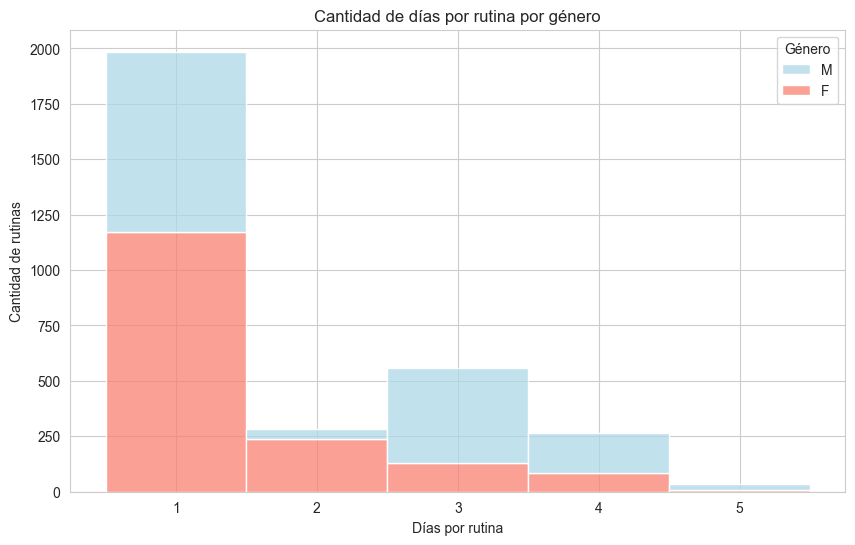

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, x='day', hue='gender', discrete=True, multiple='stack', palette={'F': 'salmon', 'M': 'lightblue'})
ax.get_legend().set_title('Género')
plt.title('Cantidad de días por rutina por género')
plt.xlabel('Días por rutina')
plt.ylabel('Cantidad de rutinas')
plt.xticks(range(1, 6))
plt.show()

## 4. Count by Date

Here we visualize the number of active client records per month.

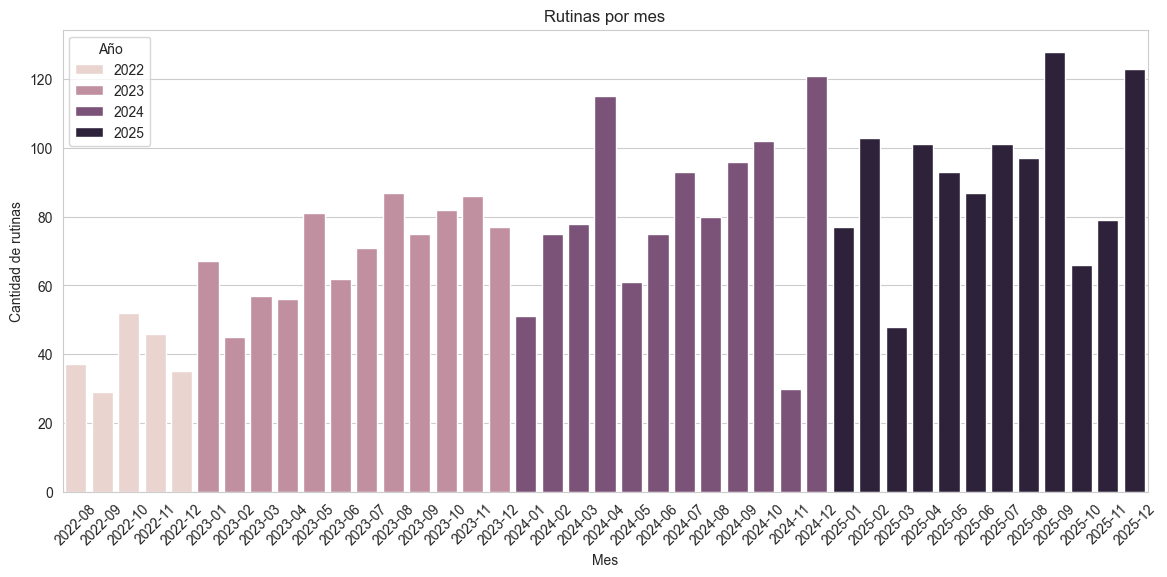

In [30]:
plt.figure(figsize=(14, 6))
# Format dates as strings for the x-axis labels to be cleaner
df['date_str'] = df['date'].dt.strftime('%Y-%m')
df['year'] = df['date'].dt.year
sns.countplot(data=df.sort_values('date'), x='date_str', hue='year', dodge=False)
plt.title('Rutinas por mes')
plt.legend(title='Año')
plt.xlabel('Mes')
plt.ylabel('Cantidad de rutinas')
plt.xticks(rotation=45)
plt.show()

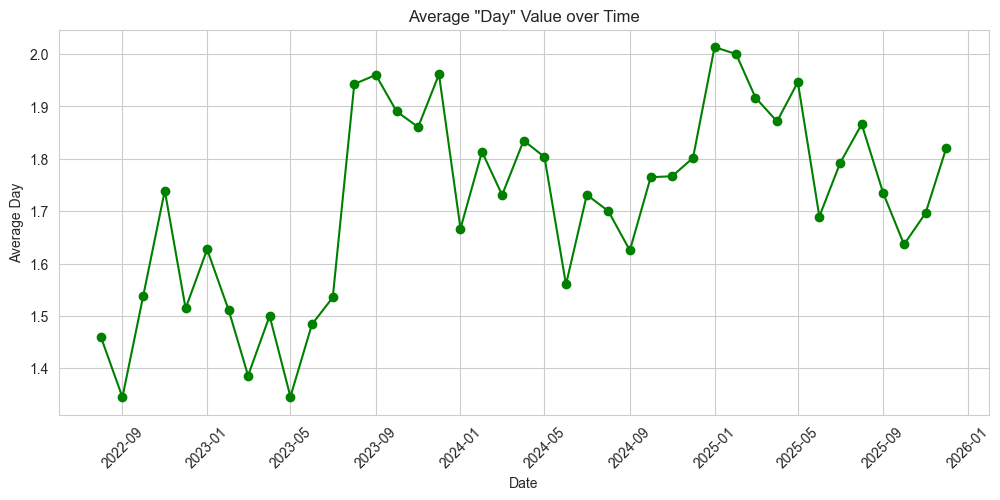

In [ ]:
plt.figure(figsize=(12, 5))
avg_day_per_month = df.groupby('date')['day'].mean()
plt.plot(avg_day_per_month.index, avg_day_per_month.values, marker='o', color='green')
plt.title('Cantidad de "días por rutina" promedio a lo largo del tiempo')
plt.xlabel('Date')
plt.ylabel('Average Day')
plt.xticks(rotation=45)
plt.grid(True)

# Number of clients per year

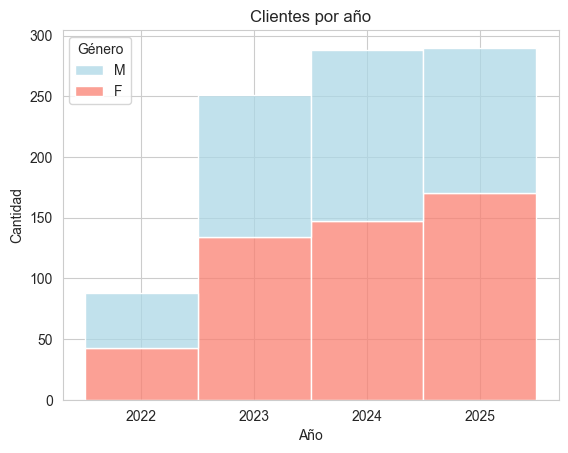

In [ ]:
clients_by_year = df.drop_duplicates(subset=['year', 'client_id'])
ax = sns.histplot(data=clients_by_year, x='year', discrete=True, hue="gender", palette={'F': 'salmon', 'M': 'lightblue'}, multiple="stack")
ax.get_legend().set_title('Género')
plt.title('Clientes activos por año')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.xticks(sorted(clients_by_year['year'].unique()))
plt.show()

# Routines per client

In [44]:
routines_per_client = df.groupby(["client_id"])["date"].count().reset_index(name="count")

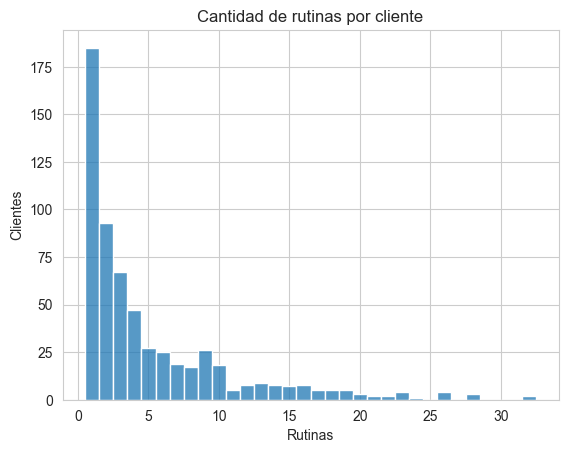

In [47]:
sns.histplot(data=routines_per_client, x="count", discrete=True, multiple="stack")
plt.title("Cantidad de rutinas por cliente")
plt.xlabel("Rutinas")
plt.ylabel("Clientes")
plt.show()